<h1><center> MANAGEMENT AND ANALYSIS OF PHYSICS DATASET (mod.B)  </center></h1>

<h1><center> Final project :  Analysis of Covid-19 papers  </center></h1>


<h2><center> Date : 23/09/2020 , University of Padua </center></h2>

<h3><center> Authors : Camilla Quaglia (1242830) , Edoardo Antonaci (1234431) and Walter Zigliotto  (1230665) </center></h3>

## Second Part

In [ ]:
from dask.distributed import Client
from dask import delayed
import time
import json
import os
import dask.bag as db
import re
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The papers with the content in one single line are imported like before

In [ ]:
path_to_json = 'data/papers_in_json/'

files = [path_to_json+pos_json for pos_json in os.listdir(path_to_json)]

path_to_one_line_json='data/papers_in_one_line_json/'

for i in range(len(files)):
    f=open(files[i],"r")
    f_one_line=open(path_to_one_line_json+os.listdir(path_to_json)[i],"w+")
    s=f.read()
    s = s.replace('\t','')
    s = s.replace('\n','')
    s =s.replace ("  ",' ')
    f_one_line.write( str( re.split("[\n]", s )[0] ) )


f_one_line.close()
f.close()


In [ ]:
filename = os.path.join('data', 'papers_in_one_line_json', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(30)

### Which are the worst and best represented countries in the research?

In this part the papers are converted in a usable DataFrame, in order to figure out the countries that are most and less active in the research. In particular we look at the country of the authors and the universities (affiliations). \
Even here multiple runs are performed by changing the number of partitions and workers and both, like previously done.

In [ ]:
client = Client() # a local cluster is set up
client

Client Scheduler: tcp://127.0.0.1:52408 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.46 GB


#### authors's countries

Firstly we pluck the author's information.

In [ ]:
# Pluck 'metadata' and then 'authors'
authors = js.pluck('metadata').pluck('authors')

In [ ]:
# Flatten information of the authors
def fun(record):
    uni=loc=lab=''
    if 'institution' in record['affiliation'].keys():
        uni=record['affiliation']['institution']
    else: uni="Unknown"
    
    if 'laboratory' in record['affiliation'].keys():
        lab=record['affiliation']['laboratory']
    else: lab="Unknown"
    
    if 'location' in record['affiliation'].keys():
        if 'country' in record['affiliation']['location'].keys():
            loc=record['affiliation']['location']['country']
        else: loc="Unknown"
    else: loc="Unknown"
    
    if uni=='': uni="Unknown"
    if lab=='': lab="Unknown"
    if loc=='': loc="Unknown"
    
    return {
        'name':       record['first'],
        'surname':    record['last'], 
        'University': uni,
        'Laboratory': lab,
        'Country':    loc,
    }

auth = authors.flatten().map(fun)

In [ ]:
auth.take(1)

({'name': 'Wei-Feng',
  'surname': 'Wang',
  'University': 'Second Military Medical University',
  'Laboratory': 'Unknown',
  'Country': 'China'},)

Here we create a Dask Dataframe from the Dask Bag 'auth' \
The way to create Dask Dataframe from a Dask Bag is described at the following link 
https://docs.dask.org/en/latest/bag-creation.html#dask.bag.core.Bag.to_dataframe

In [ ]:
df = auth.to_dataframe()
type(df)

dask.dataframe.core.DataFrame

In [ ]:
df.head()

,Country,Laboratory,University,name,surname
0,China,Unknown,Second Military Medical University,Wei-Feng,Wang
1,China,Unknown,Second Military Medical University,Yi-Long,Zhang
2,Taiwan,Unknown,Chi Mei Medical Center,Chih-Cheng,Lai
3,Taiwan,Unknown,National Taiwan University Hospital,Chen-Chen,Chu
4,Taiwan,Unknown,New Taipei City,Aristine,Cheng


We download a file named 'countries.txt' that contains the name of all the countries in the world. We do this to 'filter' the Dataframe with the proper country's names.

In [ ]:
c_names = np.loadtxt('countries.txt', delimiter='\n', dtype=str)

In [ ]:
type(c_names)
for i in c_names:
    print(i)

Afghanistan
Albania
Algeria
Andorra
Angola
Antigua & Deps
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Rep
Chad
Chile
China
Colombia
Comoros
Congo
Congo {Democratic Rep}
Costa Rica
Croatia
Cuba
Cyprus
Czech Republic
Denmark
Djibouti
Dominica
Dominican Republic
East Timor
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland {Republic}
Israel
Italy
Ivory Coast
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kiribati
Korea North
Korea South
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Lesotho
Liberia
Libya
Liechtenstein
Lithuania
Luxembourg
Macedonia
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Marshall Islands
Ma

In [ ]:
def check_country_name(country):

    if ('America' in country) or ('USA' in country):
        return 'United States'
    elif country == 'ROC':
        return 'Taiwan'
    elif country == 'Deutschland':
        return 'Germany'
    elif (country == 'UK') or (country == 'England') :
        return 'United Kingdom'
    elif country=='Schweden':
        return 'Sweden'
    elif country=='España':
        return 'Spain'
    # Check if it's in the txt file
    # i.e. if it is really is a country (not a region and so on)
    elif country in c_names:
        return country
    else:
        return None

In [ ]:
df.Country = df.Country.map(check_country_name)

In [ ]:
df.tail()

,Country,Laboratory,University,name,surname
207,None,Unknown,U. Künkel · E. Schreier · Robert Koch-Institut,Priv.-Doz,
208,None,Unknown,U. Künkel · E. Schreier · Robert Koch-Institut,Eckart,Schreier
209,None,Unidad de Cuidados Intensivos. Hospital Univer...,Unidad de Cuidados Intensivos. Hospital Univer...,E,Riestra
210,None,Unidad de Cuidados Intensivos. Hospital Univer...,Unidad de Cuidados Intensivos. Hospital Univer...,Ó,Martínez González
211,None,Unidad de Cuidados Intensivos. Hospital Univer...,Unidad de Cuidados Intensivos. Hospital Univer...,Y,Frutos Vivar


We apply the function 'value_counts()' to the column 'Country' of the Dask Dataframe 'df'...

In [ ]:
occ = df.Country.value_counts()


... and we put values of occurence in ascending order

In [ ]:
%%time
# Compute everything
occ_freq = occ.compute().sort_values(ascending=False)

Wall time: 3.21 s


In [ ]:
occ_freq.head()

China             617
United States     469
Italy             222
United Kingdom    137
Spain             122
Name: Country, dtype: int64

In [ ]:
occ_freq.tail()

Malawi         1
New Zealand    1
Ghana          1
Jordan         1
Venezuela      1
Name: Country, dtype: int64

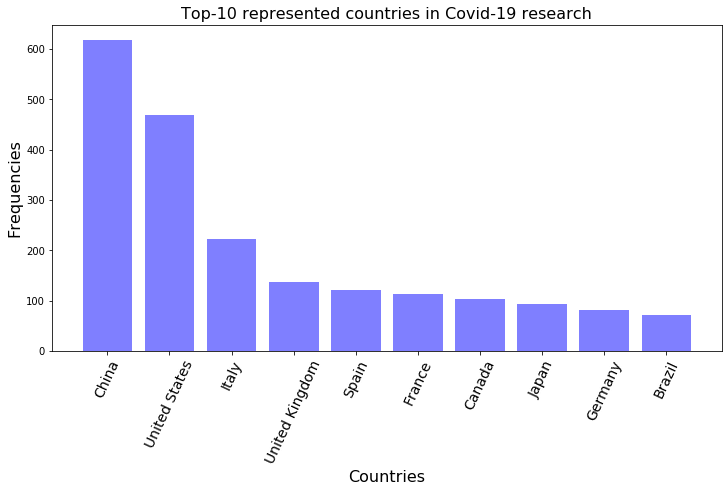

In [ ]:
# Plot best represented countries
plt.figure(figsize=(12,6))

width = 0.8 
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occ_freq.index[:10],size=14)

plt.bar(occ_freq.index[:10], occ_freq.values[:10], width, color='b',alpha=0.5)
plt.xlabel('Countries', size=16)
plt.ylabel('Frequencies', size=16)
plt.xticks(rotation=65)
plt.title('Top-10 represented countries in Covid-19 research', size=16)
plt.show()



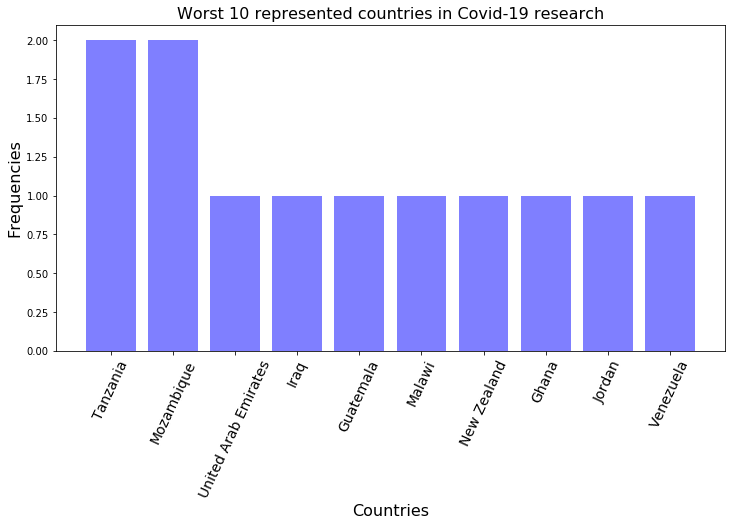

In [ ]:
# Plot best represented countries
plt.figure(figsize=(12,6))

width = 0.8 
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occ_freq.index[-10:],size=14)

plt.bar(occ_freq.index[-10:], occ_freq.values[-10:], width, color='b',alpha=0.5)
plt.xlabel('Countries', size=16)
plt.ylabel('Frequencies', size=16)
plt.xticks(rotation=65)
plt.title('Worst 10 represented countries in Covid-19 research', size=16)
plt.show()



In [ ]:
client.close()

In [ ]:
def comp_time(w,p):
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    start = time.time()
    
    #import the data
    filename = os.path.join('data', 'papers_in_one_line_json', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(p)
    
    # Pluck 'metadata' and then 'authors'
    authors = js.pluck('metadata').pluck('authors')
    auth = authors.flatten().map(fun)
    
    df = auth.to_dataframe()
    
    #apply the function 'check_country_name'
    df.Country = df.Country.map(check_country_name)
    
    occ = df.Country.value_counts()
    
    occ_freq = occ.compute().sort_values(ascending=False)
    
    end = time.time()
    client.close()
    return end-start

In [ ]:
workers = [1,2,3,4]
partitions = [1,5,20,50,100] # with the same partitions as before
                                     #the kernel stop working
t = np.zeros((len(workers),len(partitions)))
for w in range(len(workers)):
    for p in range(len(partitions)):
        t[w][p] = comp_time(workers[w],partitions[p])

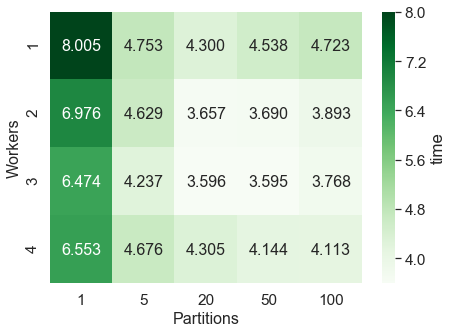

In [ ]:
df_grid = pd.DataFrame(t,workers,partitions)
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_grid,annot=True, annot_kws={"size": 16},fmt=".3f",
           cbar_kws={'label':'time'},cmap="Greens")
plt.ylabel('Workers',size=16) 
plt.xlabel('Partitions',size=16)   
plt.show()

In [ ]:
client.close()

#### University's countries

set up a local cluster

In [ ]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:53371 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.46 GB


We perform the same procedure as before with the countries of the Universities

In [ ]:
occurrences = df.University.value_counts()

In [ ]:
%%time
# Compute everything
occurrences_freq = occurrences.compute().sort_values(ascending=False)

Wall time: 3.91 s


In [ ]:
occurrences_freq

Unknown                                                                 2705
The University of Hong Kong                                               57
Verona University Hospital Trust                                          55
Chinese Academy of Sciences                                               42
University of California                                                  29
Third Military Medical University                                         27
Fudan University                                                          26
Huazhong Agricultural University                                          26
Utrecht University                                                        25
Harvard Medical School                                                    23
Huazhong University of Science and Technology                             23
Zhejiang University                                                       23
National Institutes of Health                                             23

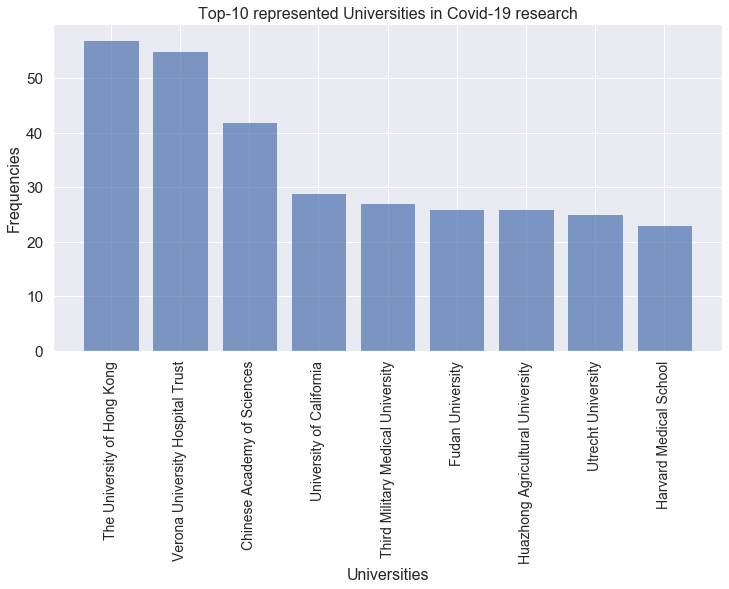

In [ ]:
# Plot best represented countries
plt.figure(figsize=(12,6))

width = 0.8 
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occurrences_freq.index[1:10],size=14)

plt.bar(occurrences_freq.index[1:10], occurrences_freq.values[1:10], width, color='b',alpha=0.7)
plt.xlabel('Universities', size=16)
plt.ylabel('Frequencies', size=16)
plt.xticks(rotation=90)
plt.title('Top-10 represented Universities in Covid-19 research', size=16)
plt.show()

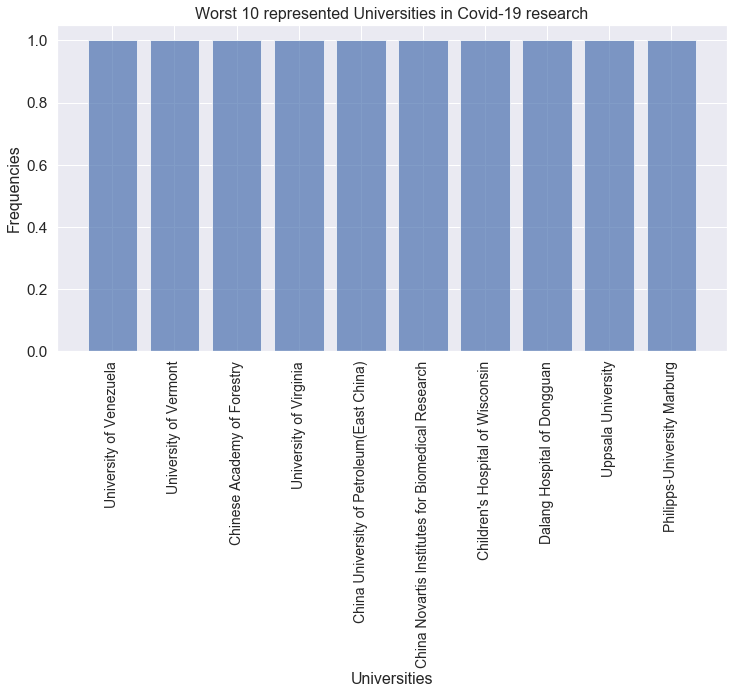

In [ ]:
# Plot best represented countries
plt.figure(figsize=(12,6))

width = 0.8 
# gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_xticklabels(occurrences_freq.index[-10:],size=14)

plt.bar(occurrences_freq.index[-10:], occurrences_freq.values[-10:], width, color='b',alpha=0.7)
plt.xlabel('Universities', size=16)
plt.ylabel('Frequencies', size=16)
plt.xticks(rotation=90)
plt.title('Worst 10 represented Universities in Covid-19 research', size=16)
plt.show()



In [ ]:
client.close()

In [ ]:
def comp_time_uni(w,p):
    
    client = Client(n_workers=w) # set up a local cluster varing the
                                  # number of workers
    start = time.time()
    
    #import the data
    filename = os.path.join('data', 'papers_in_one_line_json', '*.json')
    lines = db.read_text(filename)
    js = lines.map(json.loads).repartition(p)
    
    # Pluck 'metadata' and then 'authors'
    authors = js.pluck('metadata').pluck('authors')
    auth = authors.flatten().map(fun)
    
    df = auth.to_dataframe()
    
    occurrences = df.University.value_counts()
    
    occurrences_freq = occurrences.compute().sort_values(ascending=False)
    
    end = time.time()
    client.close()
    return end-start

In [ ]:
workers = [1,2,3,4]
partitions = [1,5,20,50,100] # with the same partitions as before
                                     #the kernel stop working
t = np.zeros((len(workers),len(partitions)))
for w in range(len(workers)):
    for p in range(len(partitions)):
        t[w][p] = comp_time_uni(workers[w],partitions[p])

Task was destroyed but it is pending!
task: <Task pending coro=<TCPClient.connect() done, defined at C:\Users\edoardo antonaci\ANACONDA\lib\site-packages\tornado\tcpclient.py:222> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x00000179984BC258>()]> cb=[IOLoop.add_future.<locals>.<lambda>() at C:\Users\edoardo antonaci\ANACONDA\lib\site-packages\tornado\ioloop.py:690]>
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (thre

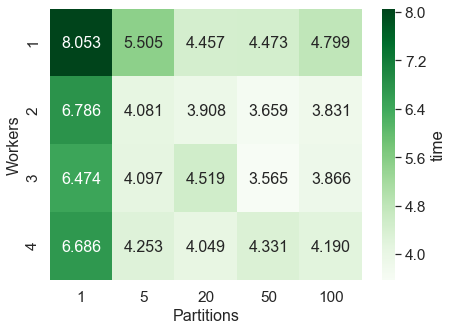

In [ ]:
df_grid = pd.DataFrame(t,workers,partitions)
plt.figure(figsize=(7,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_grid,annot=True, annot_kws={"size": 16},fmt=".3f",
           cbar_kws={'label':'time'},cmap="Greens")
plt.ylabel('Workers',size=16) 
plt.xlabel('Partitions',size=16)   
plt.show()